In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

# Exporing return profile for 15 min and 75 min period for NIFTY futures

## Table of Contents:

[setup](#setup)

In [2]:
# :: Dev Plan :: #

# Load all futures data in a single dataframe file by file
# There may be some data points where volume is low or those futures are little ahead of the time, it is better to eliminate those.
# Then create a series of 15 min/75 min return in percent
# It is better to create a series on range of the candle in percent as well
# Plot typical returns over entire data (2 years -2019 -2020)
# Plot typical returns by month
# Plot cummulative % return of the period

#Why I am plotting this?
# 1. Typical return gives idea how much I'll make/loose on the trade x% of time ~ 75% time
# 2. Is range significantly different for returns ~ This may translate in hitting stops or targets.
# 3. Typicall mean reversion behaviour ~ how much cummulative returns.

### 1. Setting up the Notebook <a id='setup'></a>

In [3]:
# Imports
import sys
import logging
from typing import Dict
import glob

import numpy as np
import pandas as pd

import unittest

import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

from kneed import KneeLocator
from scipy.stats import shapiro

In [4]:
# Logging (Requires restart for log level change)

logging.basicConfig(stream=sys.stdout, level=logging.INFO)
logger = logging.getLogger('LOGGER_NAME')

In [5]:
# unit test settings

runtests = True

In [6]:
# Resource Folders

DATA_DIR = './../data/'

In [7]:
# Constants and Statics

COLUMN_NAMES = ['Instrument', 'Date', 'Time', 'Open', 'High', 'Low', 'Close', 'Volume', 'Open Interest']
OHLC_CONVERSION_DICT: Dict[str, str] = {'Instrument' : 'first',
                                        'Open': 'first',
                                        'High': 'max',
                                        'Low': 'min',
                                        'Close': 'last',
                                        'Volume': 'sum',
                                        'Open Interest': 'last'}

#### 2. Loading Data

In [8]:
# A function for loading fut file in to a dataframe

def load_data(csv_file_path : str) -> pd.DataFrame:
    data = pd.read_csv(csv_file_path, header=None, index_col=None,
                                      names=COLUMN_NAMES,
                                      parse_dates=[['Date', 'Time']])
    data.set_index('Date_Time', inplace=True)
    return data

In [9]:
# Load data files in a list

data_file_path_list = []
for name in glob.glob(DATA_DIR+'NIFTY[0-9]*FUT.csv'):
    data_file_path_list.append(name)

logger.debug(data_file_path_list[:3])

In [10]:
# Convert a 1 min data to 15 min Candle. dropna() drops any time windows outside business hours

def aggregate_to_15Min(data : pd.DataFrame) -> pd.DataFrame:
    min15_data = data.resample('15min', origin='start').agg(OHLC_CONVERSION_DICT)
    min15_data.dropna(how='any', inplace=True)
    return min15_data

In [11]:
# Convert a 1 min data to 75 min Candle

def aggregate_to_75min(data : pd.DataFrame) -> pd.DataFrame:
    min15_data = aggregate_to_15Min(data)
    index_dates = pd.Series(np.unique(min15_data.index.date))
    list_of_min75_data_by_date = []
    for idx_date in index_dates:
        idx_date_str = idx_date.strftime(format='%Y-%m-%d')
        min75_data_by_date = min15_data[idx_date_str].resample('75Min', origin='start').agg(OHLC_CONVERSION_DICT)
        list_of_min75_data_by_date.append(min75_data_by_date)

    min75_data = pd.concat(list_of_min75_data_by_date)
    return min75_data

In [12]:
# Calculate percent return for n period

def calculate_pct_returns(price_series : pd.Series, n : int) -> pd.Series:
    n_returns = (price_series/price_series.shift(n) - 1)*100
    n_returns = n_returns.dropna()
    return n_returns

In [13]:
# Create 15 min dataframes and combine across all future data files

pct_returns_15min_temp = [calculate_pct_returns(aggregate_to_15Min(load_data(csv_file_path= file_path))['Close'], n=1).values for file_path in data_file_path_list]
pct_returns_15min = [ret for series_ret in pct_returns_15min_temp for ret in series_ret]
logger.debug('Total number of series : %d' % len(pct_returns_15min_temp))
logger.debug('Total number of returns : %d' % len(pct_returns_15min))

#### 3. Analysis

In [14]:
# Basic statistics for 15 min return

logger.info('Mean percent returns for {} datapoints : {}'.format(len(pct_returns_15min), np.mean(pct_returns_15min)))
logger.info('25 percentile : {} '.format(np.percentile(pct_returns_15min, 25)))
logger.info('50 percentile : {} '.format(np.percentile(pct_returns_15min, 50)))
logger.info('75 percentile : {} '.format(np.percentile(pct_returns_15min, 75)))

logger.info('Min : {} , Max : {}'.format(np.min(pct_returns_15min), np.max(pct_returns_15min)))

INFO:LOGGER_NAME:Mean percent returns for 26766 datapoints : -0.0005974887112947541
INFO:LOGGER_NAME:25 percentile : -0.07650115709487149 
INFO:LOGGER_NAME:50 percentile : 0.0008486339057589554 
INFO:LOGGER_NAME:75 percentile : 0.07925424489853006 
INFO:LOGGER_NAME:Min : -12.001867995018678 , Max : 6.57749332236377


##### 3.1 Distribution of percent return on 15 Min interval

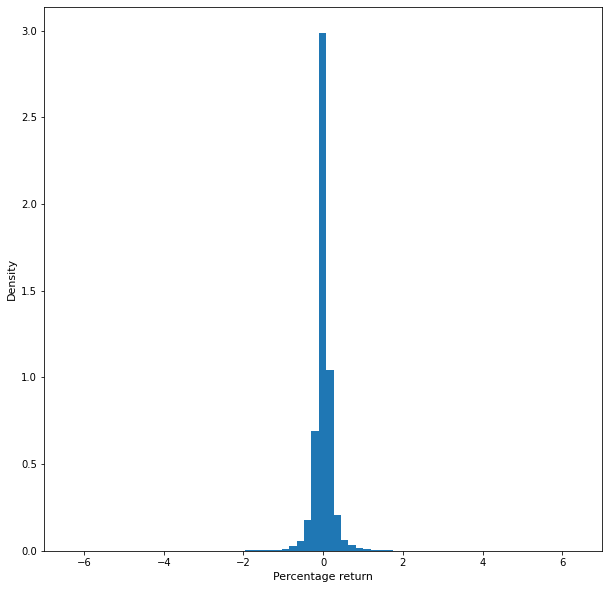

In [15]:
# Visualize histogram of returns to check the distribution

ret_series = pd.Series(pct_returns_15min)
fig, ax = plt.subplots(figsize = (10,10))

ret_series.plot(kind = "hist", density = True, bins = 100)

ax.set_xlabel('Distribution of 15 min returns on NIFTY futures', fontsize=15)
ax.set_xlabel('Percentage return', fontsize=11)
ax.set_ylabel('Density', fontsize=11)

ax.set_xlim(-7, 7)

plt.show()

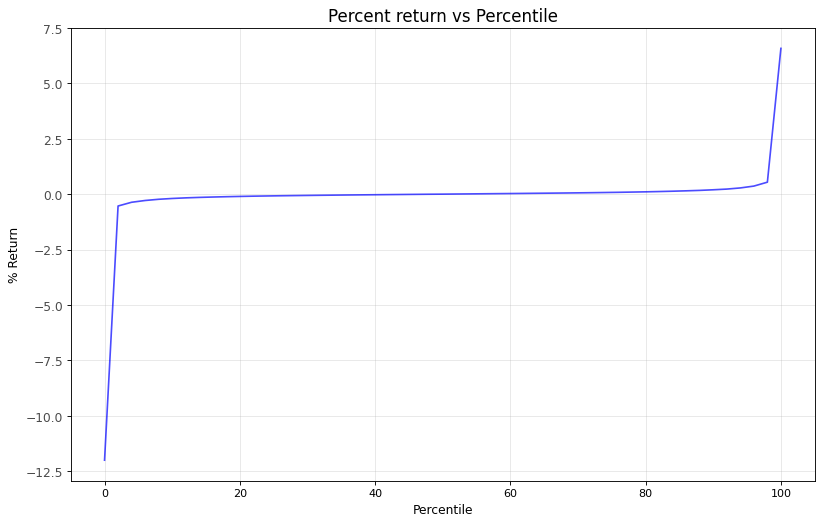

In [16]:
# Visualize how percentile covers the distribution

percentile_x = np.linspace(0.0, 100.0, num=51)
pct_return_y =  [np.percentile(pct_returns_15min, i) for i in percentile_x]

plt.figure(figsize=(12,7.5), dpi= 80)
plt.plot(percentile_x, pct_return_y, color='blue', alpha = 0.7)

plt.yticks(fontsize=11, alpha=.7)
plt.title('Percent return vs Percentile', fontsize=15)
plt.grid(axis='both', alpha=.3)
plt.ylabel('% Return', fontsize=11)
plt.xlabel('Percentile', fontsize=11)

plt.show()

In [17]:
# Observations
#- NIFTY percent returns are in range (-0.076, 0.079) for 50% of times.
# Returns are mostly centered around 0.

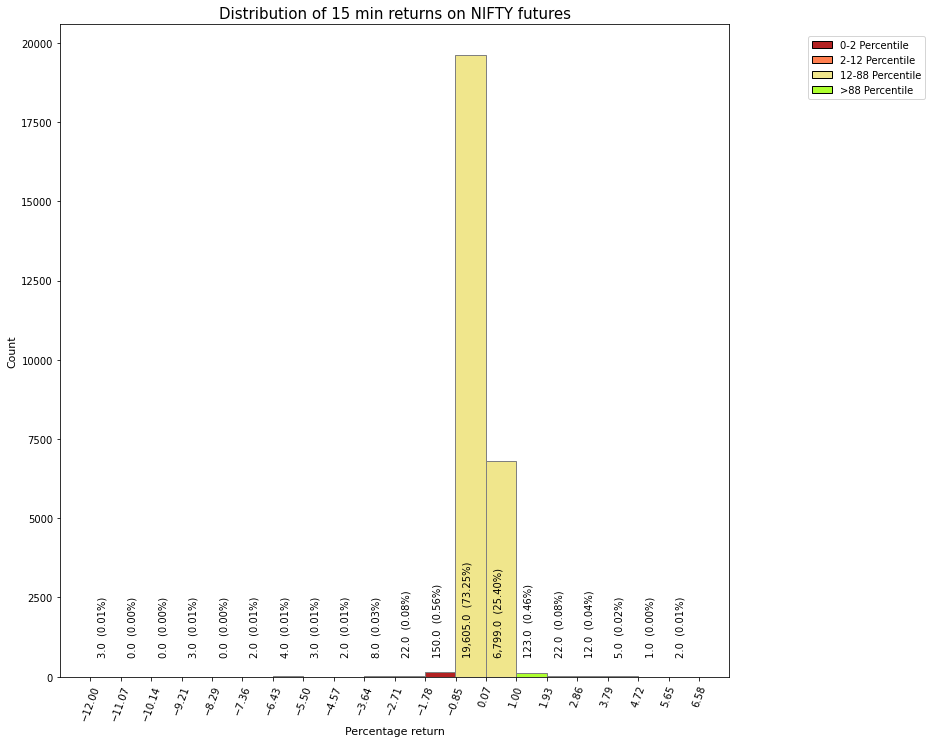

In [18]:
# Visualize returns as histogram

perc_2_colour = 'FireBrick'
perc_12_colour = 'Coral'
perc_12_to_88_colour = 'Khaki'
perc_88_colour = 'GreenYellow'

fig, ax = plt.subplots(figsize=(12,12))

'''
counts  = numpy.ndarray of count of data ponts for each bin/column in the histogram
bins    = numpy.ndarray of bin edge/range values
patches = a list of Patch objects.
        each Patch object contains a Rectnagle object. 
        e.g. Rectangle(xy=(-2.51953, 0), width=0.501013, height=3, angle=0)
'''
counts, bins, patches = ax.hist(pct_returns_15min, facecolor=perc_12_to_88_colour, edgecolor='gray', bins=20)


# Set the ticks to be at the edges of the bins.
ax.set_xticks(bins.round(2))
plt.xticks(rotation=70)

# Set the graph title and axes titles
plt.title('Distribution of 15 min returns on NIFTY futures', fontsize=15)
plt.ylabel('Count', fontsize=11)
plt.xlabel('Percentage return', fontsize=11)

# Change the colors of bars at the edges
second, twelveth, eigthyeighth = np.percentile(pct_returns_15min, [2,12,88])
for patch, leftside, rightside in zip(patches, bins[:-1], bins[1:]):
    if rightside < second:
        patch.set_facecolor(perc_2_colour)
    elif leftside > eigthyeighth:
        patch.set_facecolor(perc_88_colour)
    elif rightside < twelveth:
        patch.set_facecolor(perc_12_colour)
        
# Calculate bar centre to display the count of data points and %
bin_x_centers = 0.5 * np.diff(bins) + bins[:-1]
bin_y_centers = ax.get_yticks()[1] * 0.25

# Display the the count of data points and % for each bar in histogram
for i in range(len(bins)-1):
    bin_label = "{0:,}".format(counts[i]) + "  ({0:,.2f}%)".format((counts[i]/counts.sum())*100)
    plt.text(bin_x_centers[i], bin_y_centers, bin_label, rotation=90, rotation_mode='anchor')

#create legend
handles = [Rectangle((0,0),1,1,color=c,ec="k") for c in [perc_2_colour, perc_12_colour, perc_12_to_88_colour, perc_88_colour]]
labels= ["0-2 Percentile","2-12 Percentile", "12-88 Percentile", ">88 Percentile"]
plt.legend(handles, labels, bbox_to_anchor=(0.5, 0., 0.80, 0.99))

plt.show()

##### 3.2 Normal returns by removing outliers

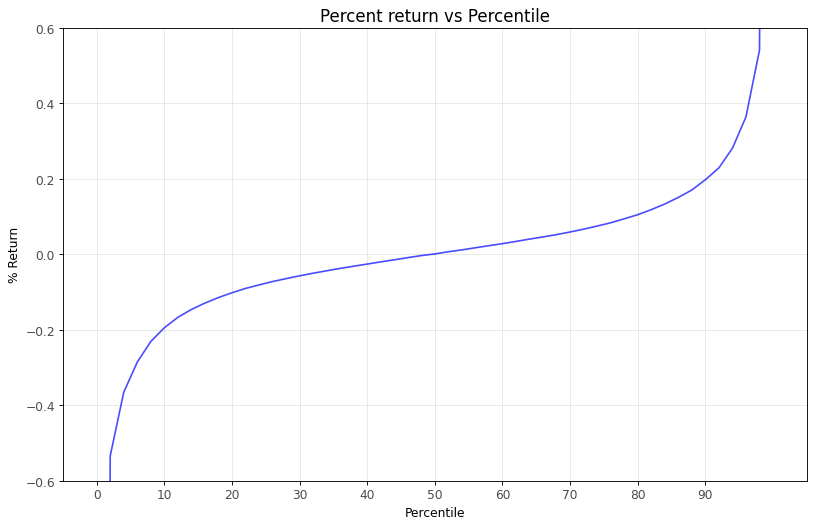

In [19]:
# Extremes on both sides dominate the visualization. limit y axis to -0.6 to 0.6

plt.figure(figsize=(12,7.5), dpi= 80)
plt.plot(percentile_x, pct_return_y, color='blue', alpha = 0.7)

plt.xticks(range(0,100,10),fontsize=11, alpha=.7)
plt.yticks(fontsize=11, alpha=.7)
plt.title('Percent return vs Percentile', fontsize=15)
plt.grid(axis='both', alpha=.3)
plt.ylabel('% Return', fontsize=11)
plt.xlabel('Percentile', fontsize=11)
plt.ylim(-0.6,0.6)

plt.show()

In [20]:
# find knee point on the curve. These points gives us precise location of normal return range. 
# Exclude first two percentile for extreme readings

first_half_x = percentile_x[1:25]
first_half_y = pct_return_y[1:25]

second_half_x = percentile_x[25:-1]
second_half_y = pct_return_y[25:-1]

kneedle_first_half = KneeLocator(first_half_x, first_half_y, S=1.0, curve="concave", direction="increasing")
knee_point_first_half = round(kneedle_first_half.knee, 3)
logger.debug('knee point for first half curve : {}'.format(knee_point_first_half))

kneedle_second_half = KneeLocator(second_half_x, second_half_y, S=1.0, curve="convex", direction="increasing")
knee_point_second_half = round(kneedle_second_half.knee, 3)
logger.debug('knee point for second half curve : {}'.format(knee_point_second_half))

In [21]:
# Remove abnormal returns from the returns to examin internal structure and distribution of returns
twelveth, eigthyeighth = np.percentile(pct_returns_15min, [12,88])
pct_returns_15min_series = pd.Series(pct_returns_15min)
normal_returns = pct_returns_15min_series[pct_returns_15min_series.between(twelveth,eigthyeighth)]

# Basic statistics for normal returns

logger.info('Mean percent returns for {} datapoints : {}'.format(len(normal_returns), np.mean(normal_returns)))
logger.info('Min : {} , Max : {}'.format(np.min(normal_returns), np.max(normal_returns)))

INFO:LOGGER_NAME:Mean percent returns for 20342 datapoints : 0.0014088452800810427
INFO:LOGGER_NAME:Min : -0.1670898404701915 , Max : 0.17031870600687782


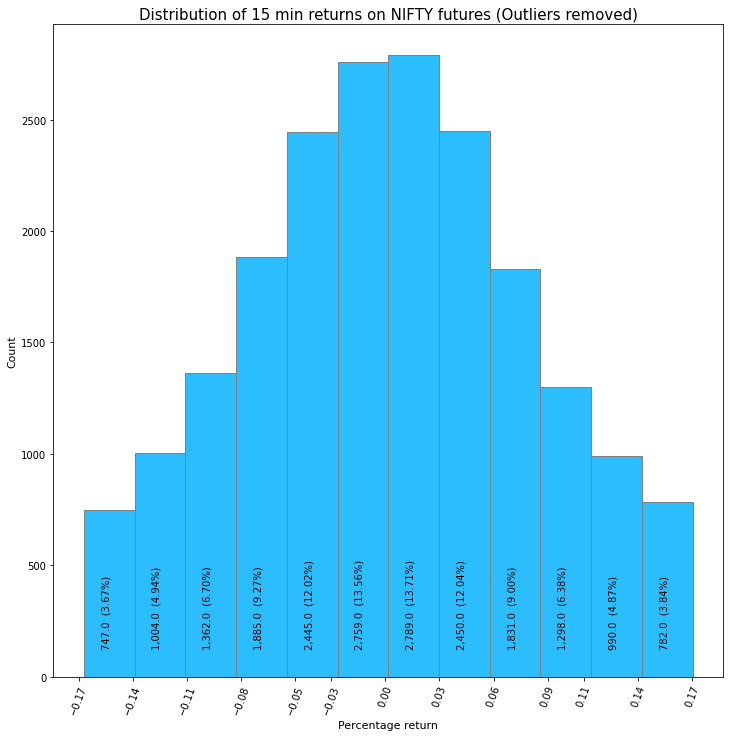

In [22]:
# Visualize returns as histogram for the most frequent range

fig, ax = plt.subplots(figsize=(12,12))

'''
counts  = numpy.ndarray of count of data ponts for each bin/column in the histogram
bins    = numpy.ndarray of bin edge/range values
patches = a list of Patch objects.
        each Patch object contains a Rectnagle object. 
        e.g. Rectangle(xy=(-2.51953, 0), width=0.501013, height=3, angle=0)
'''
counts, bins, patches = ax.hist(normal_returns, facecolor='#2CBDFE', edgecolor='gray', bins=12)


# Set the ticks to be at the edges of the bins.
ax.set_xticks(bins.round(2))
plt.xticks(rotation=70)

# Set the graph title and axes titles
plt.title('Distribution of 15 min returns on NIFTY futures (Outliers removed)', fontsize=15)
plt.ylabel('Count', fontsize=11)
plt.xlabel('Percentage return', fontsize=11)
     
# Calculate bar centre to display the count of data points and %
bin_x_centers = 0.5 * np.diff(bins) + bins[:-1]
bin_y_centers = ax.get_yticks()[1] * 0.25

# Display the the count of data points and % for each bar in histogram
for i in range(len(bins)-1):
    bin_label = "{0:,}".format(counts[i]) + "  ({0:,.2f}%)".format((counts[i]/counts.sum())*100)
    plt.text(bin_x_centers[i], bin_y_centers, bin_label, rotation=90, rotation_mode='anchor')

plt.show()

In [23]:
## Observations
# After removing outliers, probability of of value from this chart can be calculated

In [24]:
# remove extreme outliers and check if the distribution is normal

pct_returns_15min_series_wo_outliers = pct_returns_15min_series[pct_returns_15min_series.between(pct_returns_15min_series.quantile(.008), pct_returns_15min_series.quantile(.992))]
returns_15min_sample = pct_returns_15min_series_wo_outliers.sample(4000)
shapiro(returns_15min_sample)

ShapiroResult(statistic=0.9200181365013123, pvalue=8.550723229310034e-42)

In [25]:
# This is not a normal destribution.

##### Unit Tests

In [26]:
# Unit tests

class TestNotebook(unittest.TestCase):
    
    test_csv_file_path = './../data/NIFTY19MARFUT.csv'
    
    # test load data function for a single file
    def test_load_data(self):
        self.assertEqual(len(load_data(csv_file_path=self.test_csv_file_path)), 19773)
        
    def test_aggregate_to_15Min(self):
        data = load_data(csv_file_path=self.test_csv_file_path)
        data_15min = aggregate_to_15Min(data)
        self.assertEqual(len(data_15min), 1523)
        
    def test_aggregate_to_75min(self):
        data = load_data(csv_file_path=self.test_csv_file_path)
        data_75min = aggregate_to_75min(data)
        self.assertEqual(len(data_75min), 305)
        
    def test_calculate_pct_returns_period_1(self):
        series = pd.Series([100.0,101.0,101.55])
        returns = calculate_pct_returns(series, n=1)
        self.assertAlmostEqual(returns.iloc[0], 1.0)

if runtests:
    unittest.main(argv=[''], verbosity=2, exit=False)

test_aggregate_to_15Min (__main__.TestNotebook) ... ok
test_aggregate_to_75min (__main__.TestNotebook) ... ok
test_calculate_pct_returns_period_1 (__main__.TestNotebook) ... ok
test_load_data (__main__.TestNotebook) ... ok

----------------------------------------------------------------------
Ran 4 tests in 0.516s

OK


#### References:

1. Histogram visualization 
   https://towardsdatascience.com/advanced-histogram-using-python-bceae288e715
   
2. Desity function (Why it can be greater than 1 ~ not a probability) 
   https://towardsdatascience.com/histograms-and-density-plots-in-python-f6bda88f5ac0